### We will implement a rather parsiomonious Auto Encoder


<figure>
    <img src="images/autoencoder_sebastian_rashcka.png" alt="Autoencoder visualization" />
    <figcaption>Source: Raschka, S. (2021). <i>STAT 453: Machine Learning (Spring 2021)</i>. Retrieved from <a href="https://sebastianraschka.com/teaching/stat453-ss2021/" target="_blank">https://sebastianraschka.com/teaching/stat453-ss2021/</a></figcaption>
</figure>


### Downloading MNIST

In [111]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True



batch_size = 256

# Loading the data

# transforms.ToTensor() scales input images to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])


In [113]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = torch.nn.Linear(784, 32)
        self.activation = torch.nn.LeakyReLU(negative_slope=0.02)
        self.decoder = torch.nn.Linear(32, 784)

    
    def forward(self, x):
        x = self.encoder(x)
     
        x = self.activation(x)
        x = self.decoder(x)
        x = torch.sigmoid(x) # This is to ensure the values are b/w zero and one 
        return x 


In [114]:
# Pass the images on batch basis -> Batch-wise gradient descent -> Calculate loss -> Backpropagate


num_epochs = 5

start_time = time.time()

# We will be using MSE Loss
loss_fn = torch.nn.MSELoss()
model = AutoEncoder()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.train()
for i in range(num_epochs):
    for images, _ in train_loader:
       
        # Flatten the images
        images = images.view(-1, 28*28)  
        optimizer.zero_grad()
        images_decoded = model(images)
        loss = loss_fn(images_decoded, images)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{i+1}/5], Loss: {loss.item():.4f}")


        




Epoch [1/5], Loss: 0.0463
Epoch [2/5], Loss: 0.0346
Epoch [3/5], Loss: 0.0232
Epoch [4/5], Loss: 0.0199
Epoch [5/5], Loss: 0.0185


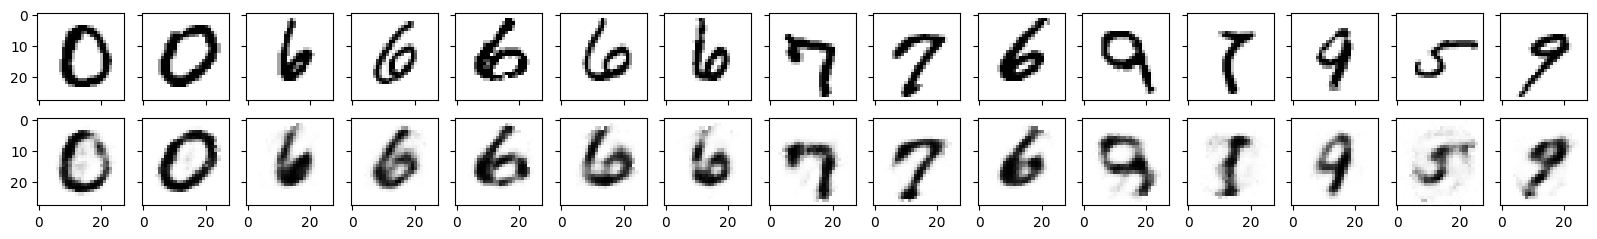

In [116]:
## Visualization
# Plot a row of original images and a row of model decoded 
import matplotlib.pyplot as plt

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = images[:n_images]
decoded_images = images_decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')